In [1]:
import torch
import faiss
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.decomposition import PCA
from torchvision import transforms as T

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1600x1062 at 0x299EA1410>


## Test DinoV2

* Load selected `DinoV2` model from PyTorch model hub
* Run inference and extract features
* Use PCA to visualise results (not necessary for our use-case)

Using cache found in /Users/michal/.cache/torch/hub/facebookresearch_dinov2_main


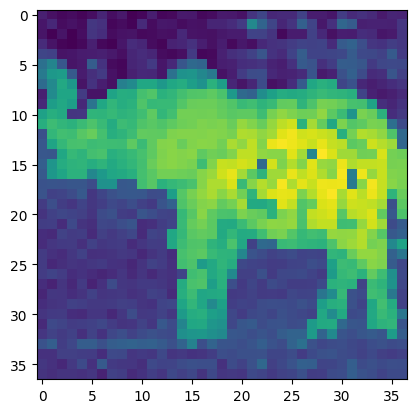

In [10]:
img = Image.open('../data/test-elephant.png')

dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

transform = T.Compose([
    T.Resize(520),
    T.CenterCrop(518),           
    T.ToTensor(),               
    T.Normalize(mean=0.5, std=0.2)
])

patch_size = dinov2.patch_size # patchsize=14

patch_h  = 520//patch_size
patch_w  = 520//patch_size

feat_dim = 1024

img = transform(img)

with torch.no_grad():
    features_dict = dinov2.forward_features(img.unsqueeze(0))
    features = features_dict['x_norm_patchtokens']

total_features = features.reshape(1 * patch_h * patch_w, feat_dim)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
plt.imshow(pca_features[:, 0].reshape(patch_h, patch_w))

plt.show()

## Test FAISS

* Create flat index (choose appropriate index size)
* Add single element to index

In [32]:
index = faiss.IndexFlatL2(features.shape[1] * features.shape[2])
index.add(features.reshape((features.shape[0], features.shape[1] * features.shape[2])).numpy())
index.ntotal

1